In [2]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXknD", "data/challenger_data.csv")


('data/challenger_data.csv', <http.client.HTTPMessage at 0x103f3eb70>)

In [3]:
import pandas as pd
df = pd.read_csv("data/challenger_data.csv")
df

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [4]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")

In [8]:
# NaNを削除
challenger_data = challenger_data[-np.isnan(challenger_data[:, 1])]

/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  


Temp (F), O-ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


Text(0.5,1,'Defects of the shuttle O-rings versus temperature')

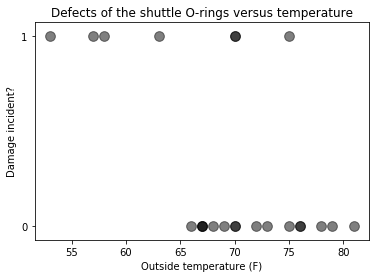

In [9]:
print("Temp (F), O-ring failure?")
print(challenger_data)
% matplotlib inline

plt.scatter(challenger_data[:, 0],
           challenger_data[:,1 ],
           s=95, color="k", alpha=0.5)

plt.yticks([0,1])
plt.ylabel("Damage incident?")
plt.xlabel("Outside temperature (F)")
plt.title("Defects of the shuttle O-rings versus temperature")

In [10]:
# 気温が下がると爆破発生率が上がっているように見える
# 以下これをロジスティクスを使ってモデリングする

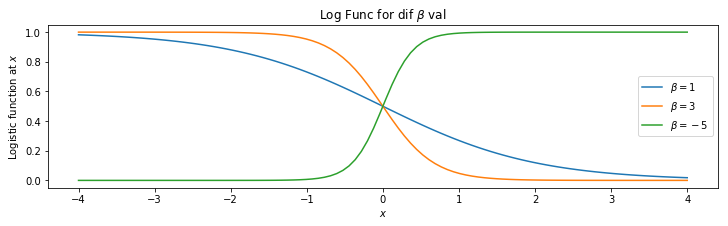

In [11]:
figsize(12,3)
def logistic(x, beta ):
    return 1.0/ (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta =  1$")
plt.plot(x, logistic(x, 3), label=r"$\beta =  3$")
plt.plot(x, logistic(x, -5), label=r"$\beta =  -5$")

plt.xlabel("$x$")
plt.ylabel("Logistic function at $x$")
plt.title(r"Log Func for dif $\beta$ val")
plt.legend()

Text(0.5,1,'Logistic fuc for diff $\\beta$ and $\\alpha$')

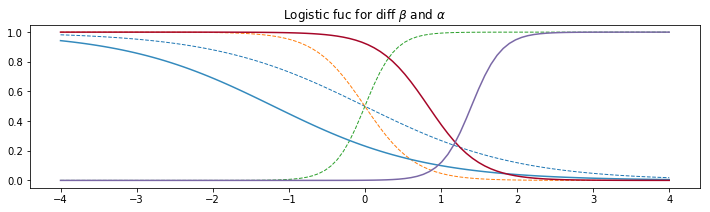

In [12]:
# データでは65度あたりから変化があるため、バイアス項αを加える
def logistic(x, beta, alpha=0):
    return 1.0/(1.0 + np.exp(np.dot(beta, x) + alpha))

x= np.linspace(-4,4,100)

plt.plot(x, logistic(x,1), label=r"$\beta =  1$", ls="--", lw=1)
plt.plot(x, logistic(x,3), label=r"$\beta =  3$", ls="--", lw=1)
plt.plot(x, logistic(x,-5), label=r"$\beta =  -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1.2), label=r"$\beta = 1, \alpha = 1$", color="#348ABD")
plt.plot(x, logistic(x, 3, -2.5), label=r"$\beta = 3, \alpha = -2$", color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$", color="#7A68A6")

plt.title(r"Logistic fuc for diff $\beta$ and $\alpha$")

Text(0,0.5,'Density func at $x$')

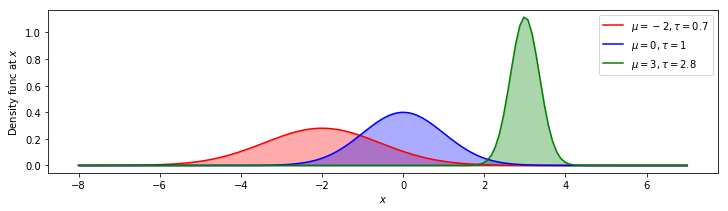

In [13]:
import scipy.stats as stats
nor = stats.norm
colors = ["red", "blue", "green"]

x = np.linspace(-8,7,150)
mu = (-2,0,3)
tau=(.7,1,2.8)
parameters=zip(mu,tau,colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
            label=r"$\mu = {}, \tau = {}$".format(_mu, _tau),
            color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau),
                    color=_color, alpha=.33)
    
plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("Density func at $x$")

In [14]:
import pymc as pm
temperature = challenger_data[:, 0]
D = challenger_data[:,1] # 破損発生かどうか

beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [15]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [16]:
# p の確率と観測データをベルヌーイ分布で結びつける
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/optimize.py:1855: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 120000 of 120000 complete in 7.6 sec

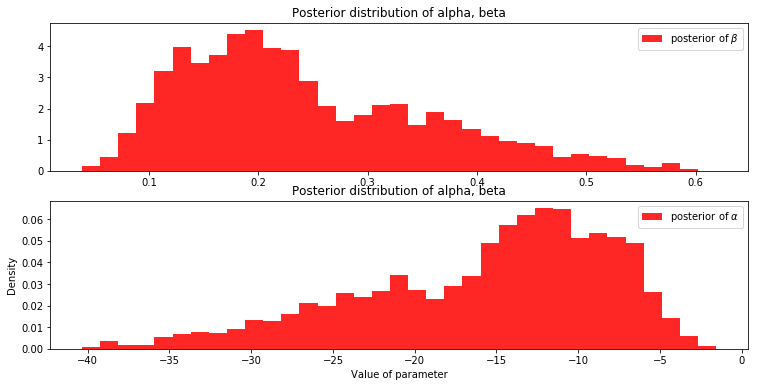

In [17]:
figsize(12.5, 6)

alpha_samples = mcmc.trace('alpha')[:, None] # １次元にする
beta_samples = mcmc.trace('beta')[:, None]

plt.subplot(211)
plt.title("Posterior distribution of alpha, beta")
plt.hist(beta_samples, histtype="stepfilled", bins=35, alpha=0.85, color="red", normed=True,
        label=r"posterior of $\beta$")
plt.legend()

plt.subplot(212)
plt.title("Posterior distribution of alpha, beta")
plt.hist(alpha_samples, histtype="stepfilled", bins=35, alpha=0.85, color="red", normed=True,
        label=r"posterior of $\alpha$")
plt.xlabel("Value of parameter")
plt.ylabel("Density")
plt.legend()



Text(0.5,0,'Temperature')

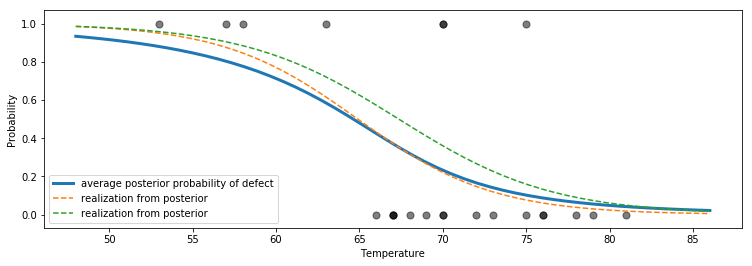

In [18]:
figsize(12.5 , 4)

t = np.linspace(temperature.min() -5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)
plt.plot(t, mean_prob_t, lw=3, label="average posterior probability of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :],ls="--",
        label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.legend()
plt.ylabel("Probability")
plt.xlabel("Temperature")

In [19]:
print(t.T.shape)
print(beta_samples.shape)
print(p_t.shape)

(1, 50)
(10000, 1)
(10000, 50)


Text(0.5,1,'Posterior probability of estimates, given temperature $t$')

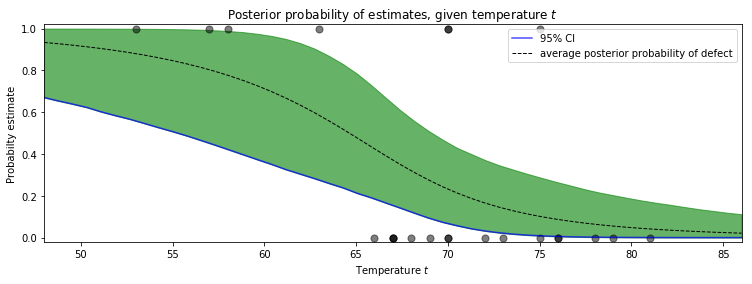

In [20]:
from scipy.stats.mstats import mquantiles

#信頼区間の上下 2.5%
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.6, color="green")

plt.plot(t[:, 0], qs[0], label="95% CI", color="blue", alpha=0.7)
plt.plot(t, mean_prob_t, lw=1, ls='--', color="k",
        label="average posterior probability of defect")
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend()

plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("Temperature $t$")
plt.ylabel("Probabilty estimate")
plt.title("Posterior probability of estimates, given temperature $t$")

Text(0.5,0,'Probability of defect occuring in O-ring')

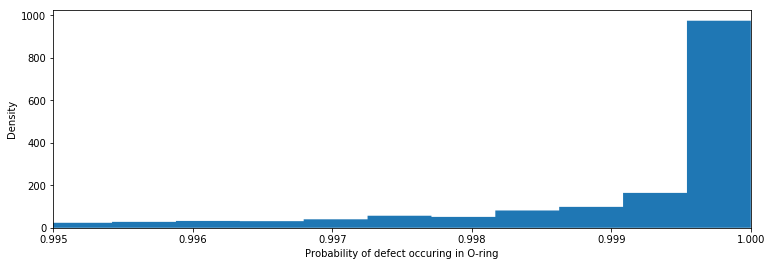

In [21]:
# 外気温 t =31のときの破損発生確率の事後分布
prob_31 = logistic(31, beta_samples, alpha_samples)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.xlim(0.995,1)
plt.ylabel("Density")
plt.xlabel("Probability of defect occuring in O-ring")

In [23]:
simulated = pm.Bernoulli("bernoulli_sim", p) # α,β=>p=>23つのサンプルデータを生成する, observedと対比される
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.3 sec

Shape of simulations array:  (10000, 23)


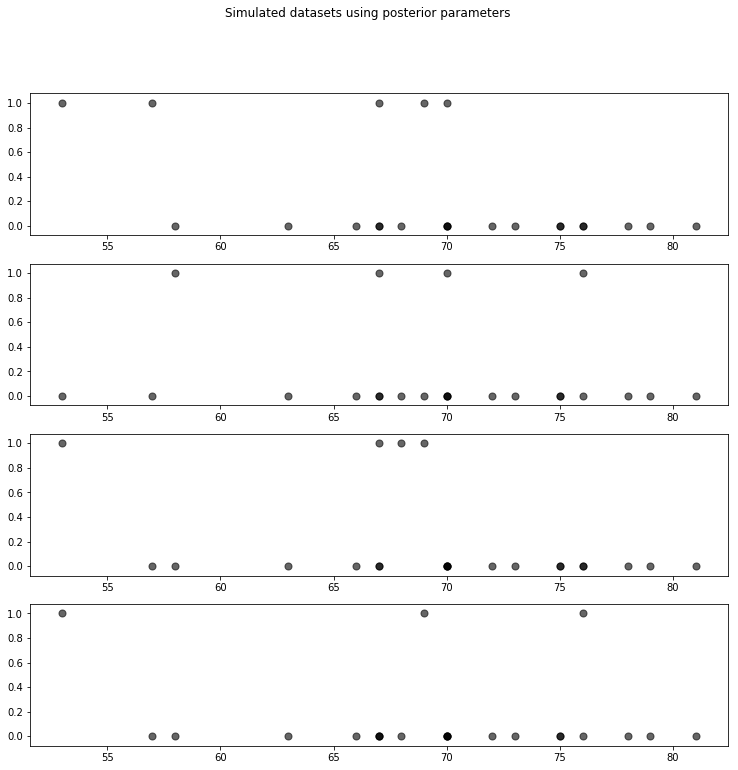

In [29]:
simulations = mcmc.trace("bernoulli_sim")[:].astype(int) # 

#生成データarrayのサイズ
print("Shape of simulations array: ", simulations.shape)
plt.suptitle("Simulated datasets using posterior parameters")

figsize(12.5, 10)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulations[1000 * i, :],
               color="k", s=50, alpha=0.6)

In [43]:
posterior_probability = simulations.mean(axis=0)

# 観測, 破損発生の有無を生成したデータ, 破損発生の事後確率, 破損発生
print("Obs. | Array of Simulated Defects | Posterior | Realized")
print("                                                     Probability  Defect  ")
print("                                                     of Defect                ")

for i in range(len(D)):
    print("%-4s | %s | %-12.2f | %d " % 
          (str(i).zfill(2),
           str(simulations[:10, i])[:-1] + "...]".ljust(6),
           posterior_probability[i], D[i]))
    

Obs. | Array of Simulated Defects | Posterior | Realized
                                                     Probability  Defect  
                                                     of Defect                
00   | [0 1 0 0 0 0 0 0 0 0...]   | 0.23         | 0 
01   | [1 0 0 0 0 0 0 0 0 0...]   | 0.13         | 1 
02   | [1 0 0 0 1 0 0 1 0 0...]   | 0.15         | 0 
03   | [0 0 0 0 0 0 0 0 0 0...]   | 0.17         | 0 
04   | [0 0 0 1 0 1 0 0 0 1...]   | 0.20         | 0 
05   | [0 0 0 0 0 0 0 0 0 0...]   | 0.10         | 0 
06   | [0 0 0 0 0 0 0 0 0 0...]   | 0.08         | 0 
07   | [0 0 0 0 0 0 0 1 0 0...]   | 0.13         | 0 
08   | [1 0 0 0 1 0 1 0 0 1...]   | 0.60         | 1 
09   | [0 0 1 0 0 0 0 0 0 0...]   | 0.35         | 1 
10   | [0 0 0 0 1 0 0 0 0 0...]   | 0.14         | 1 
11   | [0 0 0 1 0 0 0 0 0 0...]   | 0.04         | 0 
12   | [1 0 0 0 0 0 0 0 0 0...]   | 0.21         | 0 
13   | [1 1 0 0 1 0 1 0 0 0...]   | 0.73         | 1 
14   | [0 1 0 0 0 0 0 0 0 1...]  

In [45]:
ix = np.argsort(posterior_probability)

# 破損発生の事後確率、破損発生
print("Posterior Probabilty of Defect | Realized Defect")

for i in range(len(D)):
    print("%-31.2f | %d" % 
         (posterior_probability[ix[i]], D[ix[i]]))

Posterior Probabilty of Defect | Realized Defect
0.03                            | 0
0.03                            | 0
0.04                            | 0
0.05                            | 0
0.06                            | 0
0.06                            | 0
0.06                            | 1
0.08                            | 0
0.10                            | 0
0.13                            | 0
0.13                            | 1
0.13                            | 0
0.14                            | 1
0.15                            | 0
0.17                            | 0
0.20                            | 0
0.20                            | 0
0.21                            | 0
0.23                            | 0
0.35                            | 1
0.56                            | 1
0.60                            | 1
0.73                            | 1


In [46]:
urlretrieve("https://git.io/vXtye", "separation_plot.py")

('separation_plot.py', <http.client.HTTPMessage at 0x1a1599fef0>)

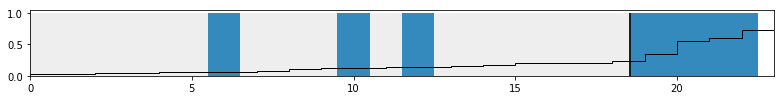

In [47]:
from separation_plot import separation_plot

figsize(11, 1.5)
separation_plot(posterior_probability, D)

Text(0.5,1,'Constant-prediction model')

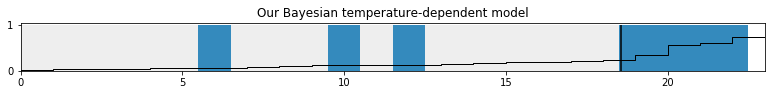

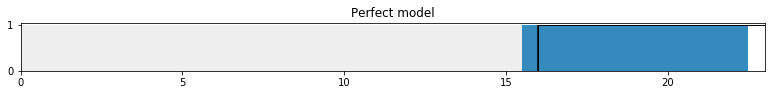

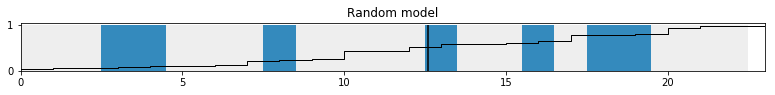

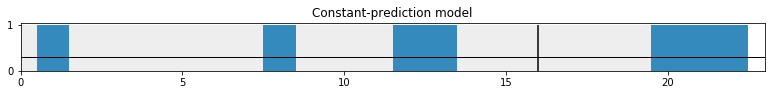

In [48]:
figsize(11, 1.25)

# ベイズ的気温依存モデル
separation_plot(posterior_probability, D)
plt.title("Our Bayesian temperature-dependent model")

# 完全モデル 　確率が実際の値と一致
p = D
separation_plot(p, D)
plt.title("Perfect model")

# ランダムモデル
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# 定数モデル
constant_prob = 7. / 23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model")

Text(0,0.5,'$\\beta$')

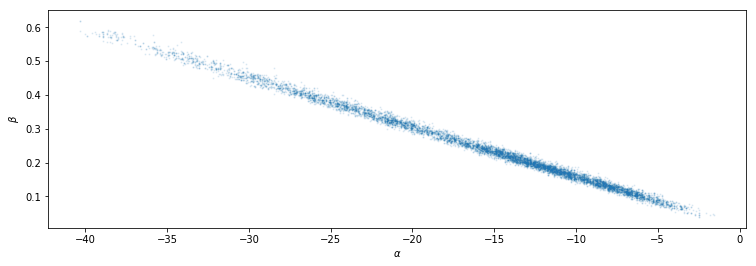

In [52]:
# 練習問題

figsize(12.5, 4)
plt.scatter(alpha_samples, beta_samples, alpha=0.1, s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")